# Comparison with different CPU Frequencies

# Parsing and Plotting Functions

In [27]:
#parse bandwidth result, each test is repeated 3 times
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
def parse_line_cpu(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x = [int(i.split(':')[1]) for i in x]
    x=np.asarray(x,dtype='float')
    return x
def parse_line_io(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x=np.asarray(x)[2:]
    x=np.asarray(x,dtype='float')
    return x
#parse dd perf result
def parse_line_perf(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    ax=list()
    for ix in x:
        if '#' in ix:
            ix = ix.split('#')[1].strip().split(' ')[0].strip('%')
            ax.append(ix)
    ax=np.asarray(ax,dtype='float')
    return ax
def parse_line_perf_raw(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    ax=list()
    for ix in x:
        if '#' in ix:
            ix = ix.split('#')[0].strip().split(' ')[0].strip('%')
            ax.append(ix)
    ax=np.asarray(ax,dtype='float')
    return ax
# Linear Fit and Plot
def plt_fit(has_cpu1,has_io_avg,xlabel=None,ylabel=None):
    from scipy import stats
    import sys
    has_cpu1=has_cpu1
    has_io_avg=has_io_avg
    slope, intercept, r_value, p_value, std_err = stats.linregress(has_cpu1,has_io_avg)
    print 'slope:%.2f'%slope
    print 'intercept:%.2f'%intercept
    print 'r-square:%.2f'%(r_value*r_value)
    predict_y = slope*has_cpu1+intercept
    x=has_cpu1
    y=has_io_avg
    pred_error = y - predict_y
    degrees_of_freedom = len(x) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    # Plotting
    plt.plot(x, y, 'o',label='data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, predict_y, 'k-',label='fitting,r^2=%.2f'%(r_value*r_value))
    plt.legend(loc='upper left')
    plt.show()
    return slope,intercept,r_value*r_value

# Data Loading and DataFrame Construction Functions

In [6]:
def load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw):
    #parse all files
    knl_cpu=parse_line_cpu(knl_cpu_f)
    has_cpu=parse_line_cpu(has_cpu_f)
    if raw==1:
        knl_perfs=parse_line_perf_raw(knl_perf_f)
        has_perfs=parse_line_perf_raw(has_perf_f)
    else:
        knl_perfs=parse_line_perf(knl_perf_f)
        has_perfs=parse_line_perf(has_perf_f)        
    has_io=parse_line_io(has_io_f)
    knl_io=parse_line_io(knl_io_f)

    #reshaping io and perfs
    knl_perfs=knl_perfs.reshape(-1,8) # there are 8 columns in the perf result, e.g., IPC, context-switch, etc
    has_perfs=has_perfs.reshape(-1,8)

    #calculating mean/max/min
    import numpy as np
    for x in range(len(knl_io)):
        if knl_io[x] < 90:
            knl_io[x]=knl_io[x]*1024
    for x in range(len(has_io)):
        if has_io[x] < 90:
            has_io[x]=has_io[x]*1024
    import pandas as pd
    df_knl=pd.DataFrame(knl_perfs)
    df_has=pd.DataFrame(has_perfs)
    df_knl.columns=['CPUuti','Contxtsw',
                    'cpumig','pageft',
                    'ClockRate','IPC','branch','branchmis']
    df_has.columns=['CPUuti','Contxtsw',
                    'cpumig','pageft',
                    'ClockRate','IPC','branch','branchmis']

    df_knl_cpu=pd.DataFrame({'userset':knl_cpu})
    df_knl=df_knl.join(df_knl_cpu)

    df_has_cpu=pd.DataFrame({'userset':has_cpu})
    df_has=df_has.join(df_has_cpu)

    df_knl_io=pd.DataFrame({'io':knl_io})
    df_knl=df_knl.join(df_knl_io)
    df_has_io=pd.DataFrame({'io':has_io})
    df_has=df_has.join(df_has_io)
    df_has['userset']=df_has['userset'].apply(lambda x : x/1000000.0)
    df_knl['userset']=df_knl['userset'].apply(lambda x : x/1000000.0)
    return df_has,df_knl

# Analyze the Data from the test of 'dd to cscratch'

In [7]:
#log files, perf detials:
knl_perf_f="../log/dd_cscratch/knl.err"
has_perf_f="../log/dd_cscratch/haswell.err"
#user specified cpu scaling freqs
knl_cpu_f='../log/dd_cscratch/cpu_knl.txt'
has_cpu_f='../log/dd_cscratch/cpu_has.txt'
#observed io bw
has_io_f='../log/dd_cscratch/haswell.3711608.bw'
knl_io_f='../log/dd_cscratch/knl.3711609.bw'
raw=1
(df_has_raw,df_knl_raw)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
raw=0
(df_has,df_knl)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
df_knl_same=df_knl[(df_knl['userset'] <=1.4) & (df_knl['userset'] >=1.2)]
df_has_same=df_has[(df_has['userset'] <=1.4) & (df_has['userset'] >=1.2)]

In [62]:
df_has_same['IPC'].mean()/df_knl_same['IPC'].mean()

2.351694915254237

In [64]:
print df_has['IPC'].mean(),df_has['IPC'].min(),df_has['IPC'].max()
print df_knl['IPC'].mean(),df_knl['IPC'].min(),df_knl['IPC'].max()

1.18787878788 1.12 1.28
0.5325 0.52 0.55


10    1.4
11    1.3
12    1.2
Name: ClockRate, dtype: float64

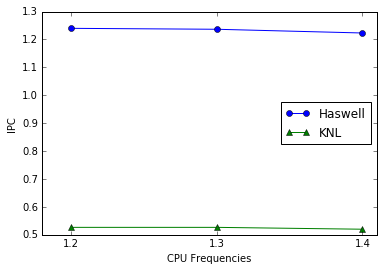

In [61]:
df_has_same_mean=df_has_same.groupby(df_has_same.index / 3).mean()
df_knl_same_mean=df_knl_same.groupby(df_knl_same.index / 3).mean()
df_has_mean=pd.to_numeric(df_has_same_mean['IPC'])
df_knl_mean=pd.to_numeric(df_knl_same_mean['IPC'])
df_has_cpu_mean=pd.to_numeric(df_has_same_mean['ClockRate']).apply(lambda x : round(x,2))
df_knl_cpu_mean=pd.to_numeric(df_knl_same_mean['ClockRate']).apply(lambda x : round(x,2))
plt.xlabel('CPU Frequencies')
plt.ylabel('IPC')
plt.plot(df_has_cpu_mean,df_has_mean,'o-',label="Haswell")
plt.plot(df_has_cpu_mean,df_knl_mean,'^-',label="KNL")
plt.legend(loc='left')
plt.xticks(df_has_cpu_mean)
plt.xlim(1.18,1.41)
df_has_cpu_mean

# IO~ClockRate on Haswell

slope:278.29
intercept:286.11
r-square:0.79


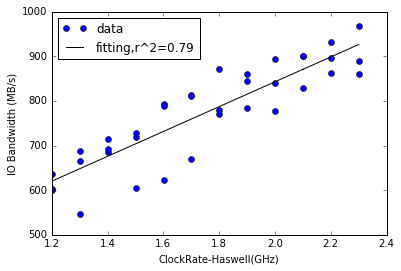

(278.2908908978855, 286.1092692292163, 0.78677263234714034)

In [9]:
plt_fit(df_has['ClockRate'][3:],df_has['io'][3:],'ClockRate-Haswell(GHz)','IO Bandwidth (MB/s)')

slope:201.30
intercept:415.31
r-square:0.76


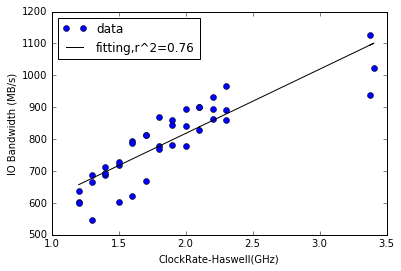

(201.30315647922004, 415.31325037589676, 0.76211345180699785)

In [10]:
plt_fit(df_has['ClockRate'],df_has['io'],'ClockRate-Haswell(GHz)','IO Bandwidth (MB/s)')

# IO~ClockRate on KNL

slope:184.33
intercept:41.28
r-square:0.95


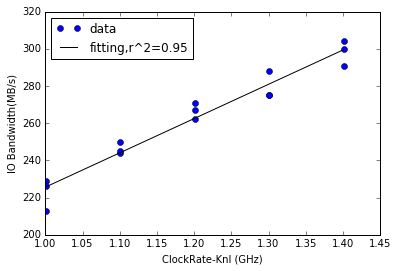

(184.33333333333331, 41.282333333333355, 0.95220139494333023)

In [125]:
plt_fit(df_knl['ClockRate'][3:],df_knl['io'][3:],'ClockRate-Knl (GHz)','IO Bandwidth(MB/s)')

slope:172.95
intercept:54.19
r-square:0.94


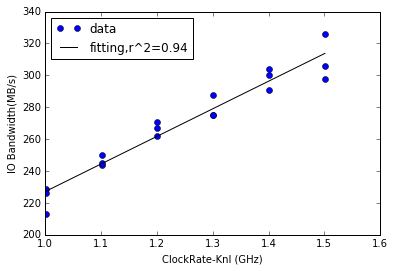

(172.95238095238096, 54.192126984126929, 0.93910171103563933)

In [12]:
plt_fit(df_knl['ClockRate'],df_knl['io']
        ,'ClockRate-Knl (GHz)','IO Bandwidth(MB/s)')

In [126]:
dic_has={}
dic_knl={}
dic_hasknl={}
frames=[df_knl_same,df_has_same]
df_hasknl=pd.concat(frames,ignore_index=True)
def plot_same():  # select the cpu-freq that both kNL and Haswell have, e..g, 1.4Ghz, then fit it with it's IO
    for icl in df_has_same.columns:
        (k,b,rs)=plt_fit(df_has_same[icl],df_has_same['io'],icl+'-haswell','IO Bandwidth')
        dic_has[icl]=rs
        (k,b,rs)=plt_fit(df_knl_same[icl],df_knl_same['io'],icl+'-knl','IO Bandwidth')
        dic_knl[icl]=rs
        (k,b,rs)=plt_fit(df_hasknl[icl],df_hasknl['io'],icl+'-hasknl','IO Bandwidth')
        dic_hasknl[icl]=rs
    print "HASWELL"
    for key, value in sorted(dic_has.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "KNL"
    for key, value in sorted(dic_knl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "HASWELL-KNL"
    for key, value in sorted(dic_hasknl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
dic_has={}
dic_knl={}
dic_hasknl={}
frames=[df_knl,df_has]
df_hasknl=pd.concat(frames,ignore_index=True)
def plot_all(): # fit and plot all data for both knl and haswell
    for icl in df_has.columns:
        (k,b,rs)=plt_fit(df_has[icl],df_has['io'],icl+'-haswell','IO Bandwidth')
        dic_has[icl]=rs
        (k,b,rs)=plt_fit(df_knl[icl],df_knl['io'],icl+'-knl','IO Bandwidth')
        dic_knl[icl]=rs
        (k,b,rs)=plt_fit(df_hasknl[icl],df_hasknl['io'],icl+'-hasknl','IO Bandwidth')
        dic_hasknl[icl]=rs
    print "HASWELL"
    for key, value in sorted(dic_has.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "KNL"
    for key, value in sorted(dic_knl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "HASWELL-KNL"
    for key, value in sorted(dic_hasknl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)

# Regression Analysis 

In [127]:
#df_hasknl
from sklearn.decomposition import PCA
pca =PCA(n_components=4)
pca.fit(df_hasknl)
#IPC + cpu-mig(K/sec) + pageft(K/sec) + ClockRate(Ghz) + branch(M/sec) + branchmis(%)

PCA(copy=True, n_components=4, whiten=False)

# Regression KNL and Haswell together

In [128]:
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_hasknl, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
#print result.summary()

# Regression Haswell only

In [129]:
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_has, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
#print result.summary()

# Regression KNL only

In [130]:
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_knl, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
#print result.summary()

In [131]:
df_has_mean=pd.to_numeric(df_has.groupby(df_has.index / 3).mean()['io'])
df_has_max=pd.to_numeric(df_has.groupby(df_has.index / 3).max()['io'])
df_has_min=pd.to_numeric(df_has.groupby(df_has.index / 3).min()['io'])
df_knl_mean=pd.to_numeric(df_knl.groupby(df_knl.index / 3).mean()['io'])
df_knl_max=pd.to_numeric(df_knl.groupby(df_knl.index / 3).max()['io'])
df_knl_min=pd.to_numeric(df_knl.groupby(df_knl.index / 3).min()['io'])

# Plot the date tegother 

In [132]:
#r-sqr>0.61
#Haswell-KNL: pagefalut, branch, branchmiss, IPC,
#KNL: branch, clockrate,pagefault, IPC
#HASWELL: pagefault, branch, Clockrate, IPC

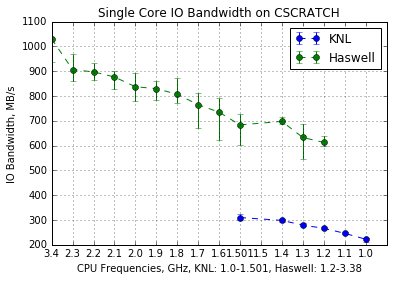

In [200]:
all_cpu=[3.38, 2.2999999999999998, 2.2000000000000002, 
         2.1000000000000001, 2.0, 1.8999999999999999, 
         1.8, 1.7, 1.6000000000000001, 1.501, 1.50,
         1.3999999999999999, 1.3, 1.2,1.1000000000000001, 1.0]
has_x=[0,1,2,3,4,5,6,7,8,9,11,12,13]
knl_x=[9,11,12,13,14,15]
plt.errorbar(knl_x,df_knl_mean, [df_knl_mean-df_knl_min, df_knl_max-df_knl_mean], fmt='--o', label="KNL")
plt.errorbar(has_x,df_has_mean, [df_has_mean-df_has_min, df_has_max-df_has_mean], fmt='--o', label="Haswell")
#plt.xticks(knl_x,knl_labels)
all_labels=["{0:.1f}".format(x) for x in all_cpu]
all_labels[9]=1.501
plt.xticks(range(16),all_labels)
plt.xlabel('CPU Frequencies, GHz, KNL: 1.0-1.501, Haswell: 1.2-3.38')
plt.ylabel('IO Bandwidth, MB/s')
plt.title('Single Core IO Bandwidth on CSCRATCH')
plt.grid(True)
plt.ylim(200,1100)
plt.legend()

In [ ]:
df_has=df_has[3:]
df_knl=df_knl[3:]
df_has_mean=pd.to_numeric(df_has.groupby(df_has.index / 3).mean()['ClockRate'])
df_has_max=pd.to_numeric(df_has.groupby(df_has.index / 3).max()['ClockRate'])
df_has_min=pd.to_numeric(df_has.groupby(df_has.index / 3).min()['ClockRate'])
df_knl_mean=pd.to_numeric(df_knl.groupby(df_knl.index / 3).mean()['ClockRate'])
df_knl_max=pd.to_numeric(df_knl.groupby(df_knl.index / 3).max()['ClockRate'])
df_knl_min=pd.to_numeric(df_knl.groupby(df_knl.index / 3).min()['ClockRate'])

#all_cpu=[3.38, 2.2999999999999998, 2.2000000000000002, 
#         2.1000000000000001, 2.0, 1.8999999999999999, 
#         1.8, 1.7, 1.6000000000000001, 1.501, 1.50,
#         1.3999999999999999, 1.3, 1.2,1.1000000000000001, 1.0]
#has_x=[0,1,2,3,4,5,6,7,8,9,11,12,13]
#knl_x=[9,11,12,13,14,15]
all_cpu=[2.2999999999999998, 2.2000000000000002, 
         2.1000000000000001, 2.0, 1.8999999999999999, 
         1.8, 1.7, 1.6000000000000001, 1.50,
         1.3999999999999999, 1.3, 1.2,1.1000000000000001, 1.0]
#df_has['userset'].indexof()
plt.errorbar(knl_x,df_knl_mean, [df_knl_mean-df_knl_min, df_knl_max-df_knl_mean], fmt='--o', label="KNL")
plt.errorbar(has_x,df_has_mean, [df_has_mean-df_has_min, df_has_max-df_has_mean], fmt='--o', label="Haswell")
#plt.xticks(knl_x,knl_labels)
all_labels=["{0:.1f}".format(x) for x in all_cpu]
all_labels[9]=1.501
plt.xticks(range(16),all_labels)
plt.xlabel('CPU Frequencies, GHz, KNL: 1.0-1.501, Haswell: 1.2-3.38')
plt.ylabel('Cycles')
plt.title('Single Core IO Cycles on CSCRATCH')
plt.grid(True)
#plt.ylim(200,1100)
plt.legend()

In [136]:
has_cpu=df_has.groupby(df_has.index / 3).mean()['ClockRate'].apply(lambda x : round(x,1))
knl_cpu=df_knl.groupby(df_knl.index / 3).mean()['ClockRate'].apply(lambda x: round(x,1))

In [202]:
#print has_k,has_b,knl_k,knl_b
cpu_same=[1.2,1.3,1.4]
a=0
#for ic in cpu_same:
#    a+=(has_k*ic+has_b)/(knl_k*ic+knl_b)
#print "With same CPU frequencies, the IO performance ratio between Haswell and KNL: %.2f"%(a/3)
#print "The peak single core IO performance ratio between Haswell and KNL: %.2f"%(max(has_io_avg)/max(knl_io_avg))

## Conclusion 1: KNL's single IO performance is more correlated with CPU frequencies than Haswell, r-square 0.94> 0.76
## Conclusion 2: With same CPU frequencies, the IO performance ratio between Haswell and KNL: 2.26
## Conclusion 3: The single core peak IO performance ratio between Haswell and KNL: 3.32

In [59]:
# Difference of Instructions, between writing to fs vs. dev/null

In [24]:
cd plot

/global/u1/j/jialin/heterogeneous-IO/cpu/plot


In [150]:
#log files, perf detials:
knl_perf_f="../log/dd_null//knl.err"
has_perf_f="../log/dd_null/has.err"
#user specified cpu scaling freqs
knl_cpu_f='../log/dd_null/cpu_knl.txt'
has_cpu_f='../log/dd_null/cpu_has.txt'
#observed io bw
has_io_f='../log/dd_null/null.haswell.3827241.bw'
knl_io_f='../log/dd_null/null.knl.3827242.bw'
raw=1
(df_has_null,df_knl_null)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
#df_knl_same=df_knl[(df_knl['userset'] <=1.4) & (df_knl['userset'] >=1.2)]
#df_has_same=df_has[(df_has['userset'] <=1.4) & (df_has['userset'] >=1.2)]

In [151]:
length_null=len(df_has_null)
length_cscratch=len(df_has)
assert(length_null==length_cscratch)
a=np.arange(0,length)

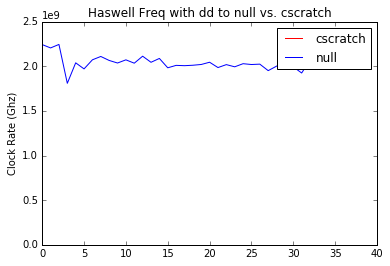

In [152]:
plt.plot(a,df_has['ClockRate'],'r',label='cscratch')
plt.plot(a,df_has_null['ClockRate'],'b',label='null')
plt.legend()
plt.ylabel('Clock Rate (Ghz)')
plt.title('Haswell Freq with dd to null vs. cscratch')

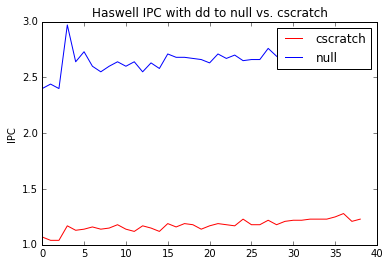

In [66]:
plt.plot(a,df_has['IPC'],'r',label='cscratch')
plt.plot(a,df_has_null['IPC'],'b',label='null')
plt.legend()
plt.ylabel('IPC')
plt.title('Haswell IPC with dd to null vs. cscratch')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


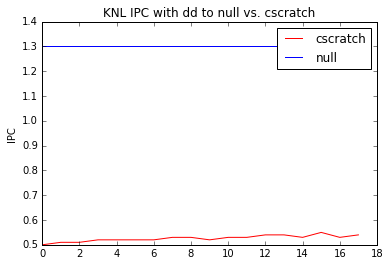

In [71]:
length_null=len(df_knl_null)
length_cscratch=len(df_knl)
assert(length_null==length_cscratch)
a=np.arange(0,length_cscratch)
print a
plt.plot(a,df_knl['IPC'],'r',label='cscratch')
plt.plot(a,df_knl_null['IPC'],'b',label='null')
plt.legend()
plt.ylabel('IPC')
plt.title('KNL IPC with dd to null vs. cscratch')

In [77]:
freq_ratio=df_has['ClockRate'].mean()/df_knl['ClockRate'].mean()
ipc_ratio=df_has['IPC'].mean()/df_knl['IPC'].mean()
print "Frequencies Ratio Haswell vs. KNL",freq_ratio
print "IPC Ratio Haswell vs. KNL",ipc_ratio

freq_ratio=df_has_null['ClockRate'].mean()/df_knl_null['ClockRate'].mean()
ipc_ratio=df_has_null['IPC'].mean()/df_knl_null['IPC'].mean()
print "Frequencies Ratio Haswell vs. KNL",freq_ratio
print "IPC Ratio Haswell vs. KNL",ipc_ratio

Frequencies Ratio Haswell vs. KNL 1.50021521245
IPC Ratio Haswell vs. KNL 2.23166274064
Frequencies Ratio Haswell vs. KNL 1.51097583472
IPC Ratio Haswell vs. KNL 2.03392504931


In [156]:
df_has_raw

,CPUuti,Contxtsw,cpumig,pageft,ClockRate,IPC,branch,branchmis,userset,io
0,6914.772601,563.0,700.0,445.0,2.333481e+10,2.497184e+10,5.187264e+09,6533949.0,2.301,1126.4
1,6988.875273,674.0,753.0,445.0,2.361114e+10,2.465142e+10,5.133762e+09,6584644.0,2.301,939.0
2,7042.502610,532.0,753.0,445.0,2.398482e+10,2.493292e+10,5.180137e+09,6494784.0,2.301,1024.0
3,9277.132157,524.0,739.0,445.0,2.134250e+10,2.496538e+10,5.185612e+09,6451292.0,2.300,861.0
4,9417.952422,402.0,618.0,445.0,2.166634e+10,2.456858e+10,5.118958e+09,5992783.0,2.300,890.0
5,9368.048905,273.0,613.0,445.0,2.155184e+10,2.463744e+10,5.131273e+09,5760481.0,2.300,968.0
6,9802.474382,438.0,129.0,445.0,2.157151e+10,2.498018e+10,5.189615e+09,6477846.0,2.200,863.0
7,9956.661458,275.0,713.0,445.0,2.191253e+10,2.494935e+10,5.181616e+09,5872133.0,2.200,896.0
8,9872.432727,278.0,692.0,445.0,2.172704e+10,2.494055e+10,5.181780e+09,6010475.0,2.200,933.0
9,10088.383269,308.0,731.0,445.0,2.119043e+10,2.498197e+10,5.190376e+09,5955256.0,2.100,900.0


In [66]:
df_knl_raw

,CPUuti,Contxtsw,cpumig,pageft,ClockRate,IPC,branch,branchmis,userset,io
0,33338.075550,211.0,637.0,443.0,5.003350e+10,2.496820e+10,5.182283e+09,73716909.0,1.401,306.0
1,32436.165453,251.0,565.0,443.0,4.867919e+10,2.470110e+10,5.137700e+09,69945739.0,1.401,298.0
2,32068.948500,93.0,474.0,443.0,4.813035e+10,2.466828e+10,5.131777e+09,66665741.0,1.401,326.0
3,34425.222587,178.0,560.0,443.0,4.822131e+10,2.493987e+10,5.176530e+09,69240724.0,1.400,304.0
4,33911.155080,230.0,633.0,443.0,4.750037e+10,2.468669e+10,5.134509e+09,67559917.0,1.400,300.0
5,34116.389137,173.0,357.0,443.0,4.778872e+10,2.468028e+10,5.134399e+09,67977463.0,1.400,291.0
6,36695.055434,306.0,828.0,443.0,4.772764e+10,2.495364e+10,5.179382e+09,69725956.0,1.300,275.0
7,36108.417362,195.0,478.0,443.0,4.696597e+10,2.471471e+10,5.139756e+09,67629396.0,1.300,275.0
8,36098.085224,71.0,959.0,443.0,4.695419e+10,2.466718e+10,5.130758e+09,66250196.0,1.300,288.0
9,39664.891508,109.0,314.0,443.0,4.762454e+10,2.495987e+10,5.181062e+09,70588209.0,1.200,262.0


In [147]:
#submit a batch job: 3853929 for ior

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


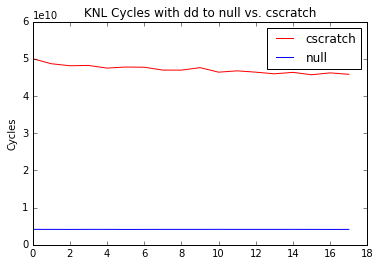

In [158]:
length_null=len(df_knl_null)
length_cscratch=len(df_knl_raw)
assert(length_null==length_cscratch)
a=np.arange(0,length_cscratch)
print a
plt.plot(a,df_knl_raw['ClockRate'],'r',label='cscratch')
plt.plot(a,df_knl_null['ClockRate'],'b',label='null')
plt.legend()
plt.ylabel('Cycles')
plt.title('KNL Cycles with dd to null vs. cscratch')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


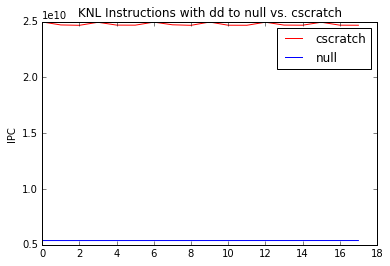

In [157]:
length_null=len(df_knl_null)
length_cscratch=len(df_knl_raw)
assert(length_null==length_cscratch)
a=np.arange(0,length_cscratch)
print a
plt.plot(a,df_knl_raw['IPC'],'r',label='cscratch')
plt.plot(a,df_knl_null['IPC'],'b',label='null')
plt.legend()
plt.ylabel('IPC')
plt.title('KNL Instructions with dd to null vs. cscratch')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


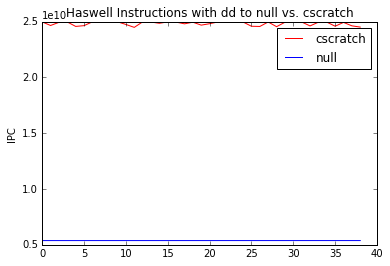

In [159]:
length_null=len(df_has_null)
length_cscratch=len(df_has_raw)
assert(length_null==length_cscratch)
a=np.arange(0,length_cscratch)
print a
plt.plot(a,df_has_raw['IPC'],'r',label='cscratch')
plt.plot(a,df_has_null['IPC'],'b',label='null')
plt.legend()
plt.ylabel('IPC')
plt.title('Haswell Instructions with dd to null vs. cscratch')

# Conclusion 4 when writting to dev/null, much less number of instructions and cycles are produced

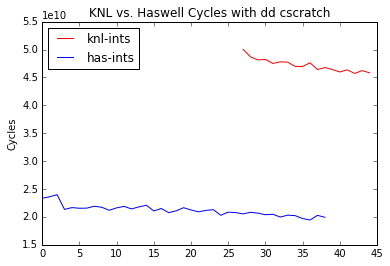

In [76]:
length_has=len(df_has_raw)
#assert(length_null==length_cscratch)
a=np.arange(0,length_has)
length_knl=len(df_knl_raw)
#assert(length_null==length_cscratch)
b=np.arange(0,length_knl)
plt.plot(27+b,df_knl_raw['ClockRate'],'r',label='knl-ints')
plt.plot(a,df_has_raw['ClockRate'],'b',label='has-ints')
plt.legend(loc='left')
plt.ylabel('Cycles')
plt.title('KNL vs. Haswell Cycles with dd cscratch')

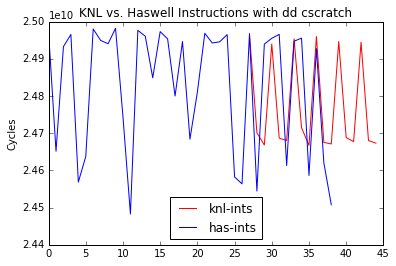

In [77]:
length_has=len(df_has_raw)
#assert(length_null==length_cscratch)
a=np.arange(0,length_has)
length_knl=len(df_knl_raw)
#assert(length_null==length_cscratch)
b=np.arange(0,length_knl)
#print a
plt.plot(27+b,df_knl_raw['IPC'],'r',label='knl-ints')
plt.plot(a,df_has_raw['IPC'],'b',label='has-ints')
plt.legend(loc='left')
plt.ylabel('Cycles')
plt.title('KNL vs. Haswell Instructions with dd cscratch')

# Try to compile on KNL, to see if there is any instruction difference, and IO difference